In [103]:
import pylab as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [104]:
class Wilson:
    def __init__(self, tau_E=1, a_E=1.2, theta_E=2.8, tau_I=2, a_I=1, theta_I=4,
                wEE=9, wEI=4, wIE=13, wII=11, I_E=0, I_I=0,
                dt=0.1, time=50):
        self.tau_E = tau_E
        self.a_E = a_E
        self.theta_E = theta_E
        self.tau_I = tau_I
        self.a_I = a_I
        self.theta_I = theta_I
        self.wEE = wEE
        self.wEI = wEI
        self.wIE = wIE
        self.wII = wII
        self.I_E = I_E
        self.I_I = I_I

        self.dt = dt
        self.range = np.arange(0, time, dt)

    def _F(self, x, a, theta):
        return (1 + np.exp(-a * (x - theta)))**-1 - (1 + np.exp(a * theta))**-1

    def _F_inverse(self, x, a, theta):
        return (-1/a)*np.log((1/(x+(1/(1+np.exp(a*theta)))))-1) +theta

    def get_nullclines(self, ai, ae):

        ai_null = (1/self.wIE)*(self.I_E + self.wEE * ae - self._F_inverse(ae, self.a_E, self.theta_E))
        ae_null = (1/self.wIE)*(-self.I_I + self.wII * ai + self._F_inverse(ai, self.a_I, self.theta_I))
        return ai_null, ae_null

    #from neuromatch tutorials
    def _OU_current(self, tau_ou, dt = 0.1, range_ = np.arange(0, 50, 0.1), sig=0.1, myseed=False):
        # Retrieve simulation parameters
        dt, range_ = dt, range_
        step_length = range_.size
        tau_ou = tau_ou  # [ms]

        # set random seed
        if myseed:
            np.random.seed(seed=myseed)
        else:
            np.random.seed()

        # Initialize
        noise = np.random.randn(step_length)
        I_ou = np.zeros(step_length)
        I_ou[0] = noise[0] * sig

        # generate OU
        for step in range(step_length-1):
            I_ou[step+1] = (I_ou[step]
                            + dt / tau_ou * (0. - I_ou[step])
                            + np.sqrt(2 * dt / tau_ou) * sig * noise[step + 1])
        return I_ou     
    
    
    def model(self, mode='const'):
        step_length = self.range.size
        ae = np.zeros(step_length)
        ae[0] = self.a_E
        ai = np.zeros(step_length)
        ai[0]= self.a_I
        if mode == 'const':
            I_E = self.I_E * np.ones(step_length)
            I_I = self.I_I * np.ones(step_length)
        elif mode=='noise':
            tau_ou = 1.
            sig_ou = 0.1
            I_E= self._OU_current(tau_ou, sig=sig_ou, myseed=1)
            I_I = self._OU_current(tau_ou, sig=sig_ou, myseed=2)
        # Simulate the Wilson-Cowan equations
        for step in range(step_length - 1):
            # Calculate the derivative of the E population
            daE = (self.dt/self.tau_E) *(- ae[step] + self._F(self.wEE * ae[step] - self.wIE *ai[step] + I_E[step], self.a_E, self.theta_E))

            # Calculate the derivative of the I population
            daI = (self.dt/self.tau_I) *(- ai[step] + self._F(self.wIE * ae[step] - self.wII *ai[step] + I_I[step], self.a_I, self.theta_I))

            # Update using Euler's method
            ae[step + 1] = ae[step] + daE
            ai[step + 1] = ai[step] + daI

        return ae, ai

    def plot_activity(self, ae, ai):
        plt.figure(figsize=(10, 6))
        plt.plot(self.range, ae, 'b', label='E population')
        plt.plot(self.range, ai, 'r', label='I population')
        plt.title('Temporal evolution of excitatory (AE, blue) and inhibitory (AI, red) activity')
        plt.ylabel('Activity')
        plt.xlabel('Time (ms)')
        plt.legend(loc='best')
        plt.show()
    
    def plot_nullclines(self):
        ae1 = np.linspace(-0.1, 0.96, 100)
        ai1 = np.linspace(-0.1, 0.96, 100)

        # Compute nullclines
        ai2, ae2 = self.get_nullclines(ai1, ae1)
        plt.figure(figsize=(10,6))
        plt.plot(ae1, ai2, 'b', label='E nullcline')
        plt.plot(ae2, ai1, 'r', label='I nullcline')
        plt.xlabel('a_E')
        plt.ylabel('a_I')
        plt.legend(loc='best')
        plt.show()


## 1. Simulate the excitatory and inhibitory population activity

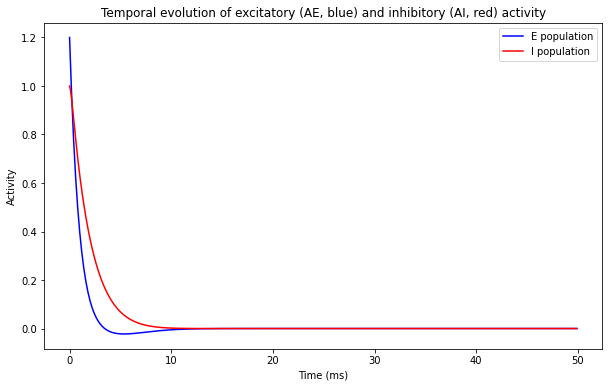

In [105]:
m = Wilson()
ae , ai = m.model()
m.plot_activity(ae, ai)

## 2. Plot the nullcline of previous setup

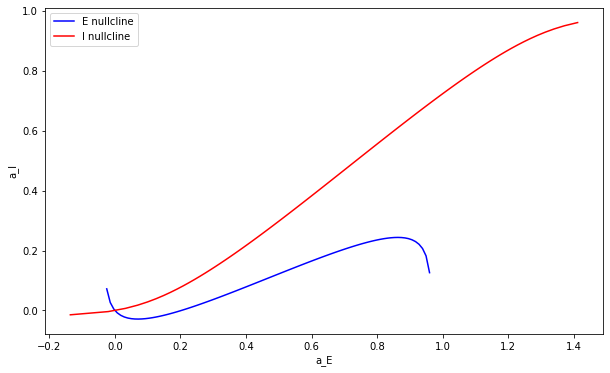

In [106]:
m.plot_nullclines()

## 3. Simulate working memory using the Wilson-Cowan model

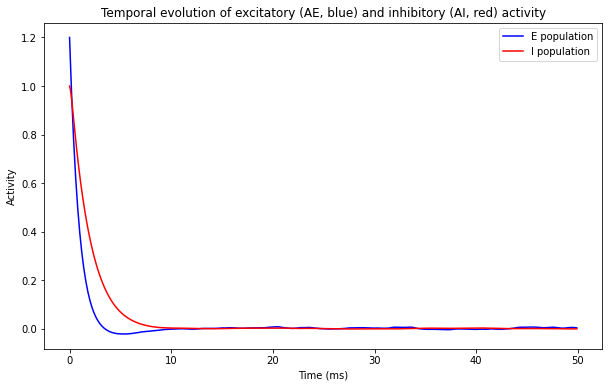

In [102]:
wm = Wilson()
ae , ai = wm.model(mode='noise')
wm.plot_activity(ae, ai)